In [1]:
import tensorflow as tf  # TensorFlow kütüphanesini içeriye alıyoruz

import os  # İşletim sistemi işlemleri için OS modülünü içeriye alıyoruz
import pathlib  # Dosya yollarıyla ilgili işlemler için pathlib modülünü içeriye alıyoruz
import time  # Zaman işlemleri için time modülünü içeriye alıyoruz
import datetime  # Tarih ve saat işlemleri için datetime modülünü içeriye alıyoruz
import cv2  # Görüntü işleme için OpenCV kütüphanesini içeriye alıyoruz

from matplotlib import pyplot as plt  # Görüntü görselleştirme için matplotlib kütüphanesini içeriye alıyoruz
from IPython import display  # IPython ortamında görsel çıktıların yönetimi için display modülünü içeriye alıyoruz

# Veri yolu
PATH = "/Users/selinoz/Downloads/archive (23)/"

# Eğitim veri kümesi boyutu
BUFFER_SIZE = 1000

# Batch boyutu
BATCH_SIZE = 1

# Giriş görüntüsünün genişliği
IMG_WIDTH = 256

# Giriş görüntüsünün yüksekliği
IMG_HEIGHT = 256


2024-06-06 15:02:33.758883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load(input_path):

    image = tf.io.read_file(input_path)
    image = tf.io.decode_jpeg(image)

    width = tf.shape(image)[1]
    width = width // 2
    input_image = image[:, :width, :]
    real_image = image[:, width:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

def resize(input_image, real_image, height, width):
    """
    Giriş ve gerçek görüntüleri belirli bir yükseklik ve genişliğe yeniden boyutlandırır.
    
    Args:
        input_image (tf.Tensor): Giriş görüntüsü tensörü.
        real_image (tf.Tensor): Gerçek görüntü tensörü.
        height (int): Yeniden boyutlandırılmış görüntünün yüksekliği.
        width (int): Yeniden boyutlandırılmış görüntünün genişliği.
    
    Returns:
        input_image (tf.Tensor): Yeniden boyutlandırılmış giriş görüntüsü tensörü.
        real_image (tf.Tensor): Yeniden boyutlandırılmış gerçek görüntü tensörü.
    """
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    """
    Giriş ve gerçek görüntüler üzerinde rastgele bir kırpma işlemi uygular.
    
    Args:
        input_image (tf.Tensor): Giriş görüntüsü tensörü.
        real_image (tf.Tensor): Gerçek görüntü tensörü.
    
    Returns:
        input_image (tf.Tensor): Kırpılmış giriş görüntüsü tensörü.
        real_image (tf.Tensor): Kırpılmış gerçek görüntü tensörü.
    """
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
    """
    Giriş ve gerçek görüntüleri normalleştirir.
    
    Args:
        input_image (tf.Tensor): Giriş görüntüsü tensörü.
        real_image (tf.Tensor): Gerçek görüntü tensörü.
    
    Returns:
        input_image (tf.Tensor): Normalleştirilmiş giriş görüntüsü tensörü.
        real_image (tf.Tensor): Normalleştirilmiş gerçek görüntü tensörü.
    """
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

@tf.function
def random_jitter(input_image, real_image):
    """
    Giriş ve gerçek görüntüleri rastgele bir dönüş ve yansıma işlemine tabi tutar.
    
    Args:
        input_image (tf.Tensor): Giriş görüntüsü tensörü.
        real_image (tf.Tensor): Gerçek görüntü tensörü.
    
    Returns:
        input_image (tf.Tensor): Döndürülmüş ve yansıtılmış giriş görüntüsü tensörü.
        real_image (tf.Tensor): Döndürülmüş ve yansıtılmış gerçek görüntü tensörü.
    """
    input_image, real_image = resize(input_image, real_image, 286, 286)

    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image


2024-06-06 15:04:54.834039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


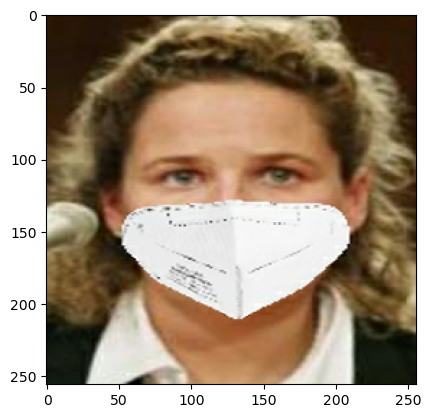

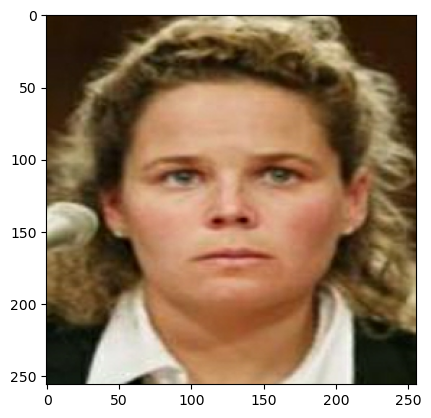

In [3]:
input_path = '/Users/selinoz/Downloads/archive (23)/test/30.jpg'

# Görüntüleri yükle
inp, re = load(input_path)

# Görüntüleri matplotlib ile göstermek için int'e dönüştür
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)


In [4]:
def load_image_train(image_file):
    # Görüntü dosyasını yükle ve işle
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_test(image_file):
    # Görüntü dosyasını yükle ve işle
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [5]:
train_dataset = tf.data.Dataset.list_files(PATH + 'train/*.jpg')

# Her bir görüntü dosyası üzerinde işlem yaparak eğitim veri kümesini oluştur
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)

# Veri kümesini karıştır
train_dataset = train_dataset.shuffle(BUFFER_SIZE)

# Küçük veri yığınlarına bölmek için eğitim veri kümesini yığınla
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(PATH + 'test/*.jpg')

# Her bir görüntü dosyası üzerinde işlem yaparak test veri kümesini oluştur
test_dataset = test_dataset.map(load_image_test)

# Küçük veri yığınlarına bölmek için test veri kümesini yığınla
test_dataset = test_dataset.batch(BATCH_SIZE)

print(train_dataset)
print(test_dataset)


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None))>


In [6]:
# `downsample` fonksiyonu, görüntü boyutunu azaltmak için kullanılır.
# Fonksiyon, bir `Conv2D` katmanı oluşturur ve görüntü boyutunu belirli bir faktörle azaltır.
# Daha sonra, elde edilen özellik haritasını daha iyi öğrenmek için LeakyReLU aktivasyon fonksiyonunu uygular.
# Toplu normalizasyon kullanılır, çünkü eğitimi daha hızlı ve daha kararlı hale getirebilir.
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

# `upsample` fonksiyonu, görüntü boyutunu artırmak için kullanılır.
# Fonksiyon, bir `Conv2DTranspose` katmanı oluşturur ve görüntüyü belirli bir faktörle büyütür.
# Bu işlem, daha düşük çözünürlüklü özellik haritalarını daha yüksek çözünürlüklü özellik haritalarına dönüştürmek için kullanılır.
# Toplu normalizasyon genellikle kullanılır, çünkü bu, eğitimi daha hızlı ve daha kararlı hale getirebilir.
# Ayrıca, isteğe bağlı olarak dropout gibi düzenleme teknikleri de kullanılabilir.

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


In [7]:
# `Generator` modeli, verilen bir giriş görüntüsünden yüksek kaliteli bir çıkış görüntüsü oluşturur.

def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Aşağı örnekleme (downsampling) aşaması
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    # Yukarı örnekleme (upsampling) aşaması
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,
                                           4,
                                           strides=2,
                                           padding="same",
                                           kernel_initializer=initializer,
                                           activation="tanh")  # (batch_size, 256, 256, 3)

    x = inputs

    # Aşağı örnekleme aşaması boyunca özellik haritalarını geçir
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Yukarı örnekleme ve bağlantı aşaması
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()


In [8]:
# GAN kaybı (Generative Adversarial Network loss), üretilen görüntünün gerçekçiliğini değerlendirir.
# L1 kaybı (Mean Absolute Error), üretilen görüntünün gerçek görüntüye ne kadar benzediğini ölçer.

# LAMBDA değeri, L1 kaybının GAN kaybına göre önemini ayarlamak için kullanılır.
# Daha yüksek LAMBDA değeri, L1 kaybının GAN kaybına göre daha fazla etkisi olur.

LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    # Üretilen görüntü için GAN kaybı hesaplanır.
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Üretilen görüntü ile gerçek görüntü arasındaki L1 kaybı hesaplanır.
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    # Toplam üreteci kaybı, GAN kaybı ile L1 kaybının LAMBDA ile ağırlıklı toplamıdır.
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [9]:
# Diskriminator, üretilen görüntünün gerçek veya sahte olduğunu belirlemeye çalışır.
# Giriş olarak, orijinal ve hedef (gerçek) görüntüler alır ve bir çıktı üretir.

def Discriminator():
    # Ağırlıkların başlangıç değerlerini belirlemek için rastgele normal dağılım kullanılır.
    initializer = tf.random_normal_initializer(0., 0.02)

    # Giriş katmanları oluşturulur, giriş olarak orijinal ve hedef görüntüler alınır.
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    # Girişler birleştirilerek tek bir tensör oluşturulur.
    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    # Aşağı ölçekleme katmanları, ağın giriş görüntülerini küçültmek için kullanılır.
    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    # Sıfır dolgu eklenerek boyut korunur ve daha fazla özellik haritası oluşturulur.
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    # Evrişim katmanı, görüntüdeki özelliklerin daha karmaşık özelliklere dönüştürülmesine yardımcı olur.
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    # Ağırlık normalizasyonu, modelin daha hızlı ve daha istikrarlı öğrenmesine yardımcı olur.
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    # Leaky ReLU, aktivasyon fonksiyonu olarak kullanılır ve modelin öğrenme yeteneğini artırır.
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    # Sıfır dolgu eklenerek boyut korunur ve daha fazla özellik haritası oluşturulur.
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    # Evrişim katmanı, nihai kararları almak için özellik haritasını işler.
    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

# Diskriminator modeli oluşturulur.
discriminator = Discriminator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


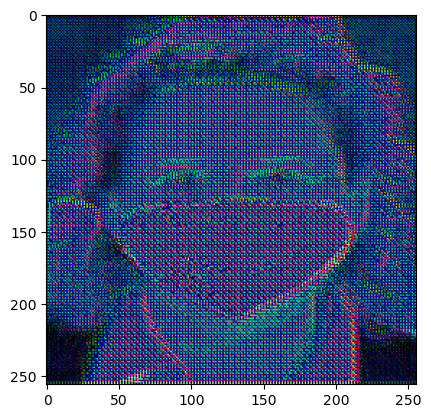

In [10]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [11]:
# Diskriminator kaybı, gerçek ve üretilen görüntüler arasındaki farkı hesaplar ve
# toplam diskriminator kaybını döndürür.

def discriminator_loss(disc_real_output, disc_generated_output):
    # Gerçek görüntüler için BinaryCrossentropy kaybı hesaplanır.
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    # Üretilen görüntüler için BinaryCrossentropy kaybı hesaplanır.
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    # Toplam diskriminator kaybı, gerçek ve üretilen kayıpların toplamıdır.
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


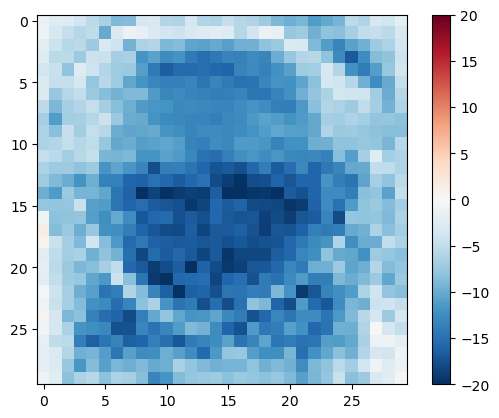

In [12]:
# Diskriminator çıktısı, bir görüntünün ne kadar gerçekçi olduğunu belirler.


disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)

# Diskriminator çıktısının görselleştirilmesi için bir renk haritası kullanılır.
# Görüntü yelpazesinin minimum ve maksimum değerleri belirlenir.
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')

# Renk barı eklenir.
plt.colorbar()


In [13]:
# Generator ve diskriminator için optimize edici oluşturulur
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Eğitim sırasında modelin kontrol noktalarının kaydedileceği dizin belirlenir
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Modelin durumu ve optimize edicileri kontrol etmek için bir kontrol noktası oluşturulur
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [14]:
def generate_images(model, test_input, tar):
    # Modeli kullanarak giriş görüntüsüne dayalı olarak bir tahmin oluşturulur
    prediction = model(test_input, training=True)
    
    # Görüntüleri görselleştirmek için bir figür oluşturulur
    plt.figure(figsize=(15, 15))

    # Görselleştirme listesi oluşturulur: giriş görüntüsü, gerçek görüntü ve tahmin edilen görüntü
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    # Her bir görüntüyü çizmek için bir döngü oluşturulur
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Görüntü piksel değerleri [0, 1] aralığına getirilir ve çizilir
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


(1, 256, 256, 3)


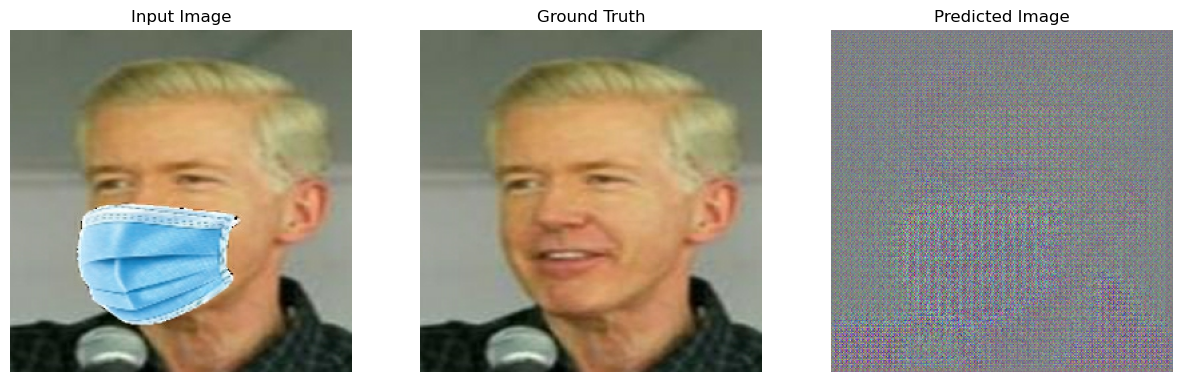

In [15]:
for example_input, example_target in test_dataset.take(1):
    # Örnek giriş ve hedef görüntülerin şeklini yazdırır
    print(example_input.shape)
    # generate_images fonksiyonunu kullanarak modelin tahminini ve gerçek hedef görüntüsünü görselleştirir
    generate_images(generator, example_input, example_target)


Time taken for 1000 steps: 4115.56 sec



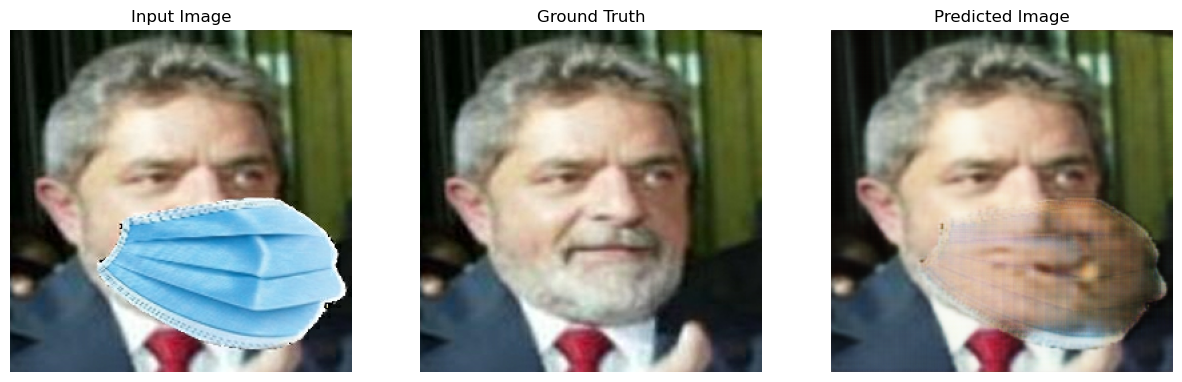

Step: 14k
Generator Total Loss: 29.414377212524414
Generator GAN Loss: 2.239109516143799
Generator L1 Loss: 0.2717526853084564
Discriminator Loss: 1.4307042360305786
...........................................................

2024-06-07 18:54:41.598443: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: /Users/selinoz/Downloads/archive (23)/train/9857.jpg; No such file or directory
2024-06-07 18:54:46.697610: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: /Users/selinoz/Downloads/archive (23)/train/4101.jpg; No such file or directory
2024-06-07 18:54:51.961301: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: /Users/selinoz/Downloads/archive (23)/train/6323.jpg; No such file or directory
2024-06-07 18:54:56.427404: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: /Users/selinoz/Downloads/archive (23)/train/2207.jpg; No such file or directory
2024-06-07 18:55:04.150730: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FO

.

2024-06-07 18:55:20.393196: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: /Users/selinoz/Downloads/archive (23)/train/7708.jpg; No such file or directory
2024-06-07 18:55:26.164435: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: /Users/selinoz/Downloads/archive (23)/train/7421.jpg; No such file or directory


NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} /Users/selinoz/Downloads/archive (23)/train/9857.jpg; No such file or directory
	 [[{{node ReadFile}}]] [Op:IteratorGetNext]

In [17]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                      generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                           discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                      generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                          discriminator.trainable_variables))

def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f"Time taken for 1000 steps: {time.time()-start:.2f} sec\n")

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

            gen_output = generator(example_input, training=False)
            disc_real_output = discriminator([example_input, example_target], training=False)
            disc_generated_output = discriminator([example_input, gen_output], training=False)

            gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, example_target)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

            print(f"Generator Total Loss: {gen_total_loss.numpy()}")
            print(f"Generator GAN Loss: {gen_gan_loss.numpy()}")
            print(f"Generator L1 Loss: {gen_l1_loss.numpy()}")
            print(f"Discriminator Loss: {disc_loss.numpy()}")

        train_step(input_image, target, step)

        # Training step
        if (step + 1) % 10 == 0:
            print(".", end="", flush=True)


fit(train_dataset, test_dataset, steps=20000)